In [1]:
import glob
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

模型训练

In [3]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

我们要类别控制的话，需要随机对一些条件进行掩码，以提高模型在未知条件下预测的能力

In [4]:
def get_context_mask(c, drop_prob):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=N_CLASSES).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

In [5]:
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  2002561


为了知道模型当前试图生成什么类别，保留了一个类别名称列表。这个顺序与数据集中的标签一致。例如，当标签为3时表示dress。

In [6]:
class_names = [
    "Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

Epoch 0 | Step 000 | Loss: 1.0921515226364136 | C: Top


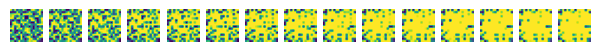

Epoch 0 | Step 100 | Loss: 0.14904746413230896 | C: Trouser


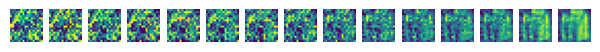

Epoch 0 | Step 200 | Loss: 0.15559105575084686 | C: Pullover


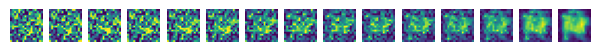

Epoch 0 | Step 300 | Loss: 0.1314873993396759 | C: Dress


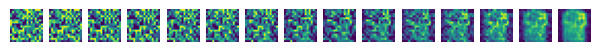

Epoch 0 | Step 400 | Loss: 0.10311612486839294 | C: Coat


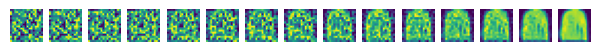

Epoch 0 | Step 500 | Loss: 0.09649132192134857 | C: Sandal


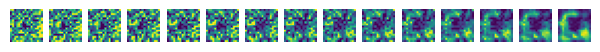

Epoch 1 | Step 000 | Loss: 0.11752546578645706 | C: Shirt


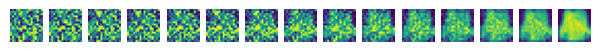

Epoch 1 | Step 100 | Loss: 0.12749262154102325 | C: Sneaker


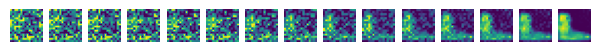

Epoch 1 | Step 200 | Loss: 0.11575035750865936 | C: Bag


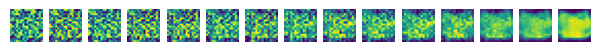

Epoch 1 | Step 300 | Loss: 0.11690674722194672 | C: Ankle boot


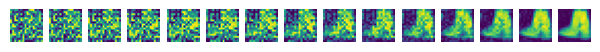

Epoch 1 | Step 400 | Loss: 0.10432736575603485 | C: Top


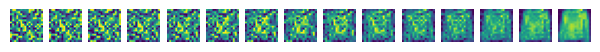

Epoch 1 | Step 500 | Loss: 0.10149258375167847 | C: Trouser


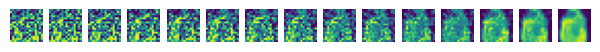

Epoch 2 | Step 000 | Loss: 0.09121818095445633 | C: Pullover


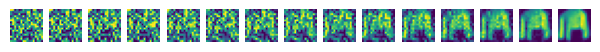

Epoch 2 | Step 100 | Loss: 0.10387460887432098 | C: Dress


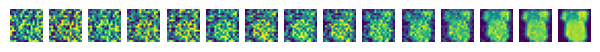

Epoch 2 | Step 200 | Loss: 0.0909883975982666 | C: Coat


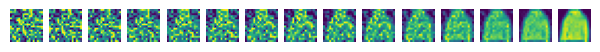

Epoch 2 | Step 300 | Loss: 0.1130470409989357 | C: Sandal


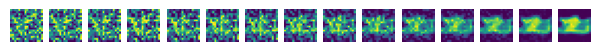

Epoch 2 | Step 400 | Loss: 0.10723596811294556 | C: Shirt


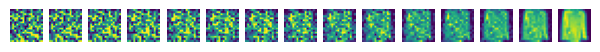

Epoch 2 | Step 500 | Loss: 0.08240460604429245 | C: Sneaker


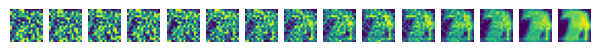

In [7]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 3
preview_c = 0

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        c_drop_prob = 0.1
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)  # New
        loss = ddpm.get_loss(model, x, t, c_hot, c_mask)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            class_name = class_names[preview_c]
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {class_name}")
            c_drop_prob = 0 # Do not drop context for preview
            c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob)
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES

Top


<Figure size 800x800 with 0 Axes>

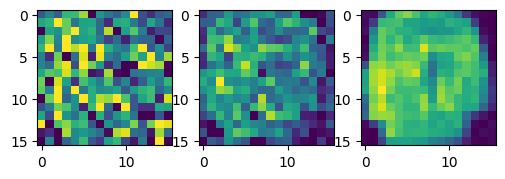

Trouser


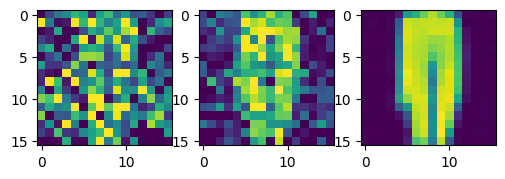

Pullover


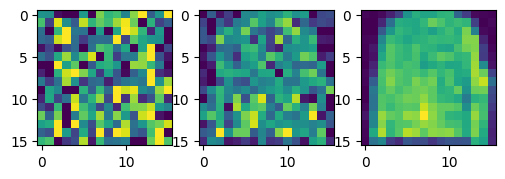

Dress


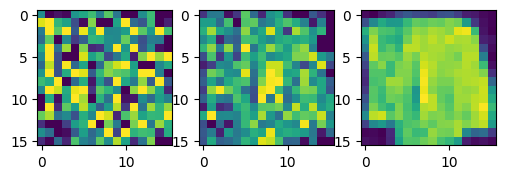

Coat


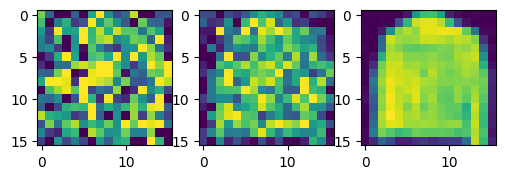

Sandal


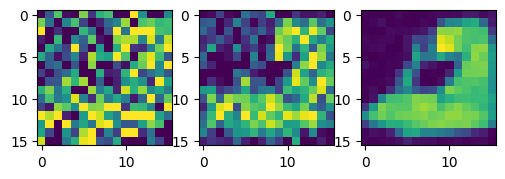

Shirt


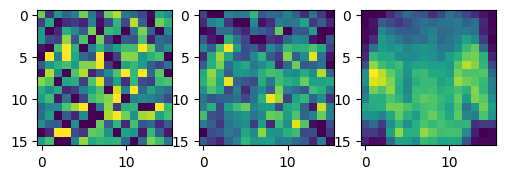

Sneaker


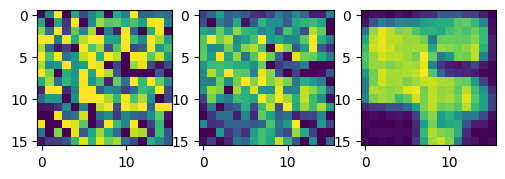

Bag


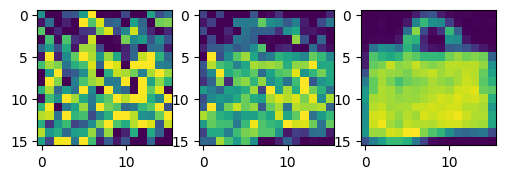

Ankle boot


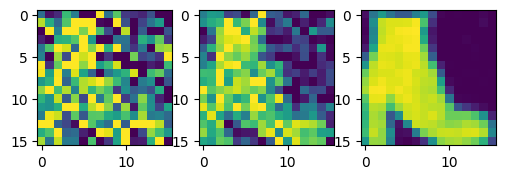

In [8]:
plt.figure(figsize=(8,8))
ncols = 3
c_drop_prob = 0 # Change me to a value between 1 and 0

for c in range(10):
    print(class_names[c])
    c_hot, c_mask = get_context_mask(torch.Tensor([c]), c_drop_prob)
    ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask, axis_on=True)

## 条件反向扩散

刚刚效果还不错，但有些类别之间仍然存在干扰。
`Classifier-Free Guidance`是一种提高生成质量和控制能力的技巧。在训练时，模型有时候带标签训练(条件的)，有时候不带(无条件)；在生成图像时，它会同时预测两个版本：有条件预测(知道类别)和无条件预测(不知道类别)。我们可以通过提高类别的权重来解决这个问题。策略如下：

- 在反向扩散的每个时间步中，我们将对图像进行**两次去噪**：
  - 第一次提取的噪声图像**保留**类别信息(记作`e_t_keep_c`)
  - 第二次提取的噪声图像**丢弃**类别信息(记作`e_t_drop_c`)
- 我们将使用以下公式从类别噪声中减去平均噪声：
  - `e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c`
  - 其中`w`是我们设定的超参数(`weight`)
- 然后我们将使用这个新的`e_t`噪声，通过`reverse_q`执行扩散操作。
- 从`t = T`到`0`重复上述步骤。

In [9]:
@torch.no_grad()
def sample_w(
    model, input_size, T, c, w_tests=[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0], store_freq=10
):
    # Preprase "grid of samples" with w for rows and c for columns
    n_samples = len(w_tests) * len(c)

    # One w for each c
    w = torch.tensor(w_tests).float().repeat_interleave(len(c))
    w = w[:, None, None, None].to(device)  # Make w broadcastable
    x_t = torch.randn(n_samples, *input_size).to(device)

    # One c for each w
    c = c.repeat(len(w_tests), 1)

    # Double the batch
    c = c.repeat(2, 1)

    # Don't drop context at test time
    c_mask = torch.ones_like(c).to(device)
    c_mask[n_samples:] = 0.0

    x_t_store = []
    for i in range(0, T)[::-1]:
        # Duplicate t for each sample
        t = torch.tensor([i]).to(device)
        t = t.repeat(n_samples, 1, 1, 1)

        # Double the batch
        x_t = x_t.repeat(2, 1, 1, 1)
        t = t.repeat(2, 1, 1, 1)

        # Find weighted noise
        e_t = model(x_t, t, c, c_mask)
        e_t_keep_c = e_t[:n_samples]
        e_t_drop_c = e_t[n_samples:]
        e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c

        # Deduplicate batch for reverse diffusion
        x_t = x_t[:n_samples]
        t = t[:n_samples]
        x_t = ddpm.reverse_q(x_t, t, e_t)

        # Store values for animation
        if i % store_freq == 0 or i == T or i < 10:
            x_t_store.append(x_t)

    x_t_store = torch.stack(x_t_store)
    return x_t, x_t_store

In [10]:
c = torch.arange(N_CLASSES).to(device)
c_drop_prob = 0  # Keep all category information for sampling
c_hot, c_mask = get_context_mask(c, c_drop_prob)
input_size = (IMG_CH, IMG_SIZE, IMG_SIZE)

x_0, x_t_store = sample_w(model, input_size, T, c_hot)

MovieWriter ffmpeg unavailable; using Pillow instead.


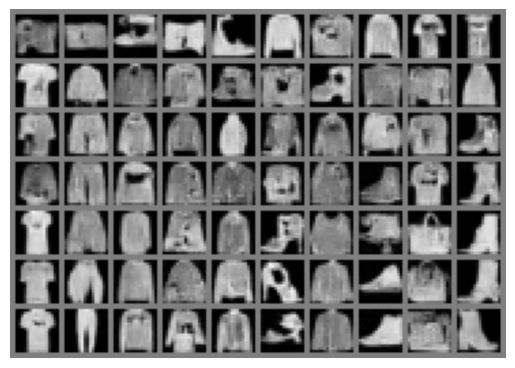

In [11]:
grids = [other_utils.to_image(make_grid(x_t.cpu(), nrow=N_CLASSES)) for x_t in x_t_store]
other_utils.save_animation(grids, "04_images/fashionMNIST.gif")

每一行表示`w`值的变化范围：从 `[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]` 依次增加。前两行是负权重，意味着模型更强调图像的平均表现而不是类别信息。这时生成的图像有时会完全不同于原本指定的类别。而最后几行则能更一致地生成符合标签的图像。

## TF Flowers数据集

现在在彩色图像上试一下：

In [12]:
IMG_SIZE = 32
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

In [13]:
import torchvision
from torch.utils.data import Dataset, DataLoader

pre_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

random_transforms = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
])

In [14]:
DATA_DIR = "data/cropped_flowers/"
DATA_LABELS = ["daisy", "sunflowers", "roses"]
N_CLASSES = len(DATA_LABELS)

data_paths = glob.glob(DATA_DIR + DATA_LABELS[0] + '/*.jpg', recursive=True)
data_paths[:5]  # First 5 paths

['data/cropped_flowers/daisy/3468498624_d082f99e98.jpg',
 'data/cropped_flowers/daisy/8382667241_0f046cecdb_n.jpg',
 'data/cropped_flowers/daisy/6095817094_3a5b1d793d.jpg',
 'data/cropped_flowers/daisy/8759177308_951790e00d_m.jpg',
 'data/cropped_flowers/daisy/7189043225_2fe781439a_n.jpg']

In [15]:
class MyDataset(Dataset):
    def __init__(self):
        self.imgs = []
        self.labels = []
        
        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(DATA_DIR + label + '/*.jpg', recursive=True)
            for path in data_paths:
                img = Image.open(path)
                self.imgs.append(pre_transforms(img).to(device))
                self.labels.append(l_idx)


    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

train_data = MyDataset()
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

U-Net结构与之前相同，但由于处理的是彩色图像，所以`T`和`down_chs`更大。

In [16]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

In [17]:
model_flowers = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model_flowers.parameters()))
model_flowers = torch.compile(model_flowers.to(device))

Num params:  44509443


采样对比函数：

In [18]:
def sample_flowers(n_classes):
    c_test = torch.arange(n_classes).to(device)
    c_hot_test, c_mask_test = get_context_mask(c_test, 0)
    x_gen, x_gen_store = sample_w(model_flowers, INPUT_SIZE, T, c_hot_test)
    return x_gen, x_gen_store

In [20]:
def train_flowers(dataloader, epochs=100, n_classes=N_CLASSES, c_drop_prob=0.1, save_dir = "04_images/"):
    lrate = 1e-4
    optimizer = torch.optim.Adam(model_flowers.parameters(), lr=lrate)

    c = torch.arange(n_classes).to(device)
    c_hot_test, c_mask_test = get_context_mask(c, 0)

    model_flowers.train()
    for epoch in range(epochs):
        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
            x = batch[0].to(device)
            c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)
            loss = ddpm.get_loss(model_flowers, x, t, c_hot, c_mask)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
        if epoch % 5 == 0 or epoch == int(epochs - 1):
            x_gen, x_gen_store = sample_flowers(n_classes)
            grid = make_grid(x_gen.cpu(), nrow=n_classes)
            save_image(grid, save_dir + f"image_ep{epoch:02}.png")
            print("saved images in " + save_dir + f" for episode {epoch}")

现在让我们看看扩散模型如何处理彩色图像：

In [21]:
train_flowers(dataloader)

Epoch 0 | Step 008 | Loss: 0.4839516580104828
saved images in 04_images/ for episode 0
Epoch 1 | Step 008 | Loss: 0.23837614059448242
Epoch 2 | Step 008 | Loss: 0.20374223589897156
Epoch 3 | Step 008 | Loss: 0.1761064976453781
Epoch 4 | Step 008 | Loss: 0.20547282695770264
Epoch 5 | Step 008 | Loss: 0.14659838378429413
saved images in 04_images/ for episode 5
Epoch 6 | Step 008 | Loss: 0.15800562500953674
Epoch 7 | Step 008 | Loss: 0.14198696613311768
Epoch 8 | Step 008 | Loss: 0.1436648666858673
Epoch 9 | Step 008 | Loss: 0.17835986614227295
Epoch 10 | Step 008 | Loss: 0.1332021951675415
saved images in 04_images/ for episode 10
Epoch 11 | Step 008 | Loss: 0.15993379056453705
Epoch 12 | Step 008 | Loss: 0.14032909274101257
Epoch 13 | Step 008 | Loss: 0.13675281405448914
Epoch 14 | Step 008 | Loss: 0.1271739900112152
Epoch 15 | Step 008 | Loss: 0.12337039411067963
saved images in 04_images/ for episode 15
Epoch 16 | Step 008 | Loss: 0.13143356144428253
Epoch 17 | Step 008 | Loss: 0.132

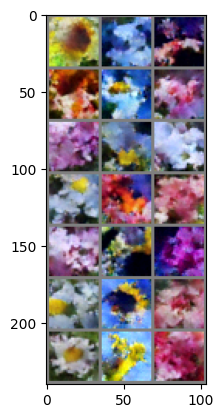

In [22]:
model.eval()
x_gen, x_gen_store = sample_flowers(N_CLASSES)
grid = make_grid(x_gen.cpu(), nrow=N_CLASSES)
other_utils.show_tensor_image([grid])
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


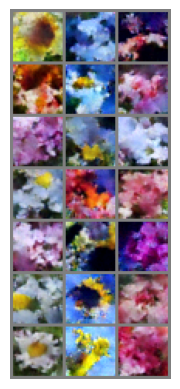

In [23]:
grids = [other_utils.to_image(make_grid(x_gen.cpu(), nrow=N_CLASSES)) for x_gen in x_gen_store]
other_utils.save_animation(grids, "04_images/flowers.gif")

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>